#Introdução

Autor: Jackson Souza Corrêa

LikedIn: https://www.linkedin.com/in/jackson-corr%C3%AAa/

GitHub: https://github.com/JacksonSCorrea

Neste notebook são desenvolvidas as etapas de Preparação dos Dados e Feature Selection para dois conjuntos de dados com target binário.

O objetivo é verificar semelhanças nas features selecionadas por cada método para os dois conjuntos de dados.

Neste notebook também contém funções desenvolvidas com o intuito de automatizar as etapas mencionadas. Assim, o desenvolvedor pode direcionar seus esforços para a interpretação dos resultados e tomada de decisão sobre as variáveis que seguirão para as etapas seguintes.

##Bibliotecas e importação dos dados

In [ ]:
# Instalação de bibliotecas
!pip install feature_engine
!pip install boruta


# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy

##Definição de funções

In [ ]:
# Função de Metadados
def report_data(df, **kwargs):

  '''
  Função que cria um dataframe resumo de valores missing e outliers no dataframe original
  Argumento obrigatório: dataframe
  Argumento opcional: k (valor do fator de multiplicação para o cálculo do limite de outliers)
  '''

  df2 = pd.DataFrame()
  df2['Feature'] = list(df.columns)
  df2['Tipo'] = df.dtypes.values
  df2['Card'] = df.nunique().values
  df2['qtd miss'] = df.isnull().sum().values
  df2['%Miss'] = round(100 * df2['qtd miss'] / df.shape[0] , 1)



  Q1 = df.quantile(0.25)    #primeiro quartil (percentil 25)
  Q3 = df.quantile(0.75)    #terceiro quartil (percentil 75)
  IIQ = Q3 - Q1             #intervalo interquartil
  k = kwargs.get('k', 1.5)  #Fator multiplicador
  LS = Q3 + k*IIQ           #Limite superior
  LI = Q1 - k*IIQ           #Limite inferior

  df2['qtd out sup'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])>LS].count().values
  df2['%Out_sup'] = round(100 * df2['qtd out sup'] / df.shape[0] , 1)


  df2['qtd out inf'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])<LI].count().values
  df2['%Out_inf'] = round(100 * df2['qtd out inf'] / df.count().values , 1)

  df2['qtd outliers'] = df2['qtd out sup'] + df2['qtd out inf']
  df2['%Outliers'] = round(100 * df2['qtd outliers'] / df.count().values , 1)


  # Inicialize um DataFrame vazio para armazenar as modas e suas frequências percentuais
  moda_e_frequencia = pd.DataFrame(columns=['Moda', 'Frequência Percentual'])

  # Itere sobre as colunas do DataFrame
  for coluna in df.columns:
      moda = df[coluna].mode().values[0]  # Encontre a moda da coluna
      frequencia = (df[coluna] == moda).mean() * 100  # Calcule a frequência percentual
      moda_e_frequencia = moda_e_frequencia.append({'Moda': moda, '%Freq': round(frequencia,1)}, ignore_index=True)

  df2['Moda'] = moda_e_frequencia['Moda']
  df2['%Freq'] = moda_e_frequencia['%Freq']


  # Cálculo da quantidade de linhas duplicadas
  dup = df.duplicated().sum()

  if dup > 0:

    # Estilo ANSI para negrito e vermelho
    negrito_vermelho = "\033[1;31m"

    # Resetar estilo ANSI (para evitar que o texto seguinte também seja vermelho)
    resetar_estilo = "\033[0m"

    print(f'\n{negrito_vermelho}Quantidade de linhas duplicadas: {dup}{resetar_estilo}\n')

    print(f'\033[1mDataframe: {df.shape[0]} linhas, {df.shape[1]} colunas\033[0m\n\n')

  df2.drop(['qtd miss','qtd out sup' , 'qtd out inf', 'qtd outliers'], axis=1 , inplace=True)


  return df2

In [ ]:
def fs_dataprep(df, target, metadados, lim_miss, lim_card, scaled):
    # Função para automação da etapa de preparação dos dados
    # Esta função salva as diversas etapas de transformação dos
    # dados de treino (X_train). Porém, nenhuma transformação é aplicada
    # nos dados de teste. A função também retorna todos os artefatos
    # utilizados na transformação

    #----------------------------------------------------------------------------------------------
    # Dropando linhas duplicadas
    df.drop_duplicates(inplace=True, keep='first')

    #----------------------------------------------------------------------------------------------
    # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage

    from sklearn.model_selection import train_test_split

    # Divisão X e Y
    X = df.drop(target, axis=1)
    y = df[target]

    # Divisão treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #----------------------------------------------------------------------------------------------
    # Dropando colunas com alto percentual de missing

    # Limites
    lim_miss = lim_miss

    # Lista de variáveis com miss acima do limiar
    lista_var = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

    # Dropando
    X_train.drop(lista_var, axis=1, inplace=True)

    #----------------------------------------------------------------------------------------------
    # Definindo colunas numéricas e categóricas
    num_var = list(X_train.select_dtypes(include=('int32','int64','float')).columns)
    cat_var = list(X_train.select_dtypes(include='object').columns)

    #----------------------------------------------------------------------------------------------
    # Imputando valores

    # Imputando valores das numéricas - 'mediana' de cada cariável
    mediana = X_train[num_var].median()
    X_train[num_var] = X_train[num_var].fillna(mediana)

    # Imputando valores das categóricas - 'sem_info'
    cat_input = 'sem_info'
    X_train[cat_var] = X_train[cat_var].fillna(cat_input)

    #----------------------------------------------------------------------------------------------
    # Codificação de variáveis categóricas

    from sklearn.preprocessing import OneHotEncoder, LabelEncoder

    # Copiando
    X_train_enc = X_train.copy()

    # Limite de cardinalidade para aplicar um ou outro encoder
    lim_card = lim_card

    # Separando variáveis de alta e baixa cardinalidade
    alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
    baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

    # Instanciando - Label Encoder nas de alta cardinalidade
    encoder = LabelEncoder()

    # Label encoder - alta cardinalidade
    X_train_enc[alta_card] = X_train_enc[alta_card].apply(lambda col: encoder.fit_transform(col))

    # Crie e aplique o OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop='first')

    # Aplicando OneHotEncoding
    encoded_data = encoder.fit_transform(X_train_enc[baixa_card])

    # Criando dataframe com as colunas codificadas, mantendo o índice original
    encoded_cols = encoder.get_feature_names_out(baixa_card)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=X_train_enc.index)

    # Concatenando o dataframe codificado com o dataframe original
    X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

    # ----------------------------------------------------------------------------------------------
    # Padronização dos dados (não precisa para árvores)
    from sklearn.preprocessing import StandardScaler

    # Criando cópia
    X_train_enc_std = X_train_enc.copy()

    # Instanciando
    scaler = StandardScaler()

    # Aplicando fit_transform
    if scaled == 'num':
        qtd_scaler = len(num_var) #Quantidade de variáveis ao qual foi aplicado o scaler
        list_var_scaled = num_var #Lista de variáveis que passarão pelo scaler
        X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica somente nas colunas originalmente numéricas

    elif scaled == 'all':
        qtd_scaler = len(list(X_train.columns)) #Quantidade de variáveis ao qual foi aplicado o scaler
        list_var_scaled = list(X_train.columns) #Lista de variáveis que passarão pelo scaler
        X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica em todas as colunas

    # ----------------------------------------------------------------------------------------------
    # Ajustando o target
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)

    # Listas adicionais
    list_var_OneHotEncoder = baixa_card
    list_var_LabelEncoder = alta_card
    list_var_drop = lista_var
    list_modes_imput = X_train.mode().iloc[0].to_dict()

    # Resumo
    resume = f'''Resumo dataprep:
    Limite de cardinalidade adotado: {lim_card}
    Limite de percentual de nulos adotado: {lim_miss}%
    Quantidade de variáveis dropadas por nulos: {len(lista_var)}
    Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
    Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
    Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''

    class DataPrepResult:
        def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                     y_train, y_test, scaler, list_var_OneHotEncoder,
                     list_var_LabelEncoder, list_var_scaled, list_var_drop,
                     list_modes_imput, resume):
            self.X_train = X_train
            self.X_train_enc = X_train_enc
            self.X_train_enc_std = X_train_enc_std
            self.X_test = X_test
            self.y_train = y_train
            self.y_test = y_test
            self.scaler = scaler
            self.list_var_OneHotEncoder = list_var_OneHotEncoder
            self.list_var_LabelEncoder = list_var_LabelEncoder
            self.list_var_scaled = list_var_scaled
            self.list_var_drop = list_var_drop
            self.list_modes_imput = list_modes_imput
            self.resume = resume

    return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                          y_train, y_test, scaler, list_var_OneHotEncoder,
                          list_var_LabelEncoder, list_var_scaled, list_var_drop,
                          list_modes_imput, resume)

In [ ]:
def fs_pca(X , variance_explained , features_per_component):

  # Feature selection com redução de dimensionalidade através do PCA
  # Método não supervisionado
  # Não indicado para quando existe a target (modelo ou análise de dados)

  from sklearn.decomposition import PCA

  # Percentual da variância que os compentes devem ser capazes de explicar
  variance = variance_explained

  # Número de features mais representativas em cada componente
  n=features_per_component

  # Instanciando - Mantendo componentes que expliquem 95% da variância do modelo
  pca = PCA(n_components = variance)

  # Treinando
  pca.fit(X)

  # Obtém os autovetores (componentes principais) e a variância explicada
  eigen_vectors = pca.components_
  explained_variance = pca.explained_variance_ratio_

  # Cria um DataFrame para armazenar as informações
  result_df = pd.DataFrame()

  # Loop através dos autovetores (componentes)
  for i in range(len(eigen_vectors)):
      # Obtém as cargas absolutas dos componentes do autovetor atual
      component_loadings = np.abs(eigen_vectors[i])

      # Ordena os índices das variáveis em ordem decrescente de carga
      sorted_indices = np.argsort(component_loadings)[::-1][:n]

      # Obtém o nome das n variáveis de maior carga
      top_n_variable_names = X.columns[sorted_indices].tolist()

      # Cria um dicionário com as informações
      info = {'Componente': f'Componente {i + 1}',
          'Vari. Expl.': explained_variance[i],}

      for j, var_name in enumerate(top_n_variable_names, start=1):
          info[f'Feature {j}'] = var_name

      # Adiciona as informações ao DataFrame
      result_df = result_df.append(info, ignore_index=True)

  # Exibe o DataFrame resultante
  result_df

  # Extrai e exibe as features selecionadas
  list_var_pca = result_df.iloc[:,2:].values
  list_var_pca = list(set(item for array in list_var_pca for item in array))

  return list_var_pca, result_df

In [ ]:
def fs_importance(X, y, cutoff_importance, plot):
  # Feature importance com RandomForest

  # Importando Random Forest
  from sklearn.ensemble import RandomForestClassifier

  # Instanciando
  rf = RandomForestClassifier(random_state=42)

  # Treinamento
  rf.fit(X, y)

  # Extraindo a importância das variáveis
  feature_importances = rf.feature_importances_
  features = pd.DataFrame({ 'Feature': X.columns, 'Importance': feature_importances })

  # Ordenar variáveis por importância
  features = features.sort_values(by='Importance', ascending=False)

  # Estabelecer um limite de corte, por exemplo, x% da importância máxima
  cutoff_maximp = cutoff_importance

  cutoff = cutoff_maximp * feature_importances.max()

  # Selecionar variáveis acima do corte
  selected_features = X.columns[feature_importances >= cutoff].tolist()

  # Selecionar variáveis abaixo do corte
  not_selected_features = X.columns[feature_importances < cutoff].tolist()

  # Visualizando a importância das variáveis em barras horizontais
  plt.figure(figsize=(10, 6))
  sorted_idx = feature_importances.argsort()

  print(f'\nFeatures removidas: {len(not_selected_features)}')

  print(f'Features remanescentes: {len(selected_features)}\n')

  if plot==True and len(features) <= 20:
    plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='dodgerblue')  # tom de azul claro
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance com Random Forest")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=cutoff, color='r', linestyle='--', label=f'Ponto de corte = {100*cutoff_maximp:.1f} %\nda importância máxima')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
  else:
    print(f'\033[1;31mO gráfico não será exibido devido a grande quantidade de features\033[0m\n')

  return selected_features

In [ ]:
def fs_variance_and_correlation(X , y , model, threshold_variance, threshold_correlation):

  # Dropagem de features com baixa variância e features altamente correlacionadas

  # ------------------------------------------------------------------------------------------------------
  # Dropando features de baixa variância

  # Definindo o limiar (queremos manter as variáveis que têm uma variância superior ao valor definido)
  # Se colocar valor 0 (zero) apenas variáveis constantes serão descartadas
  threshold = threshold_variance
  selector = VarianceThreshold(threshold)

  # Aplicando transformação (já remove as variáveis)
  selector.fit_transform(X)

  # Lista de colunas selecionadas
  selected_features = X.columns[selector.get_support()]
  discarded_features = X.columns[~selector.get_support()]

  # Eliminando
  X.drop(discarded_features , axis = 1, inplace = True)


  # ------------------------------------------------------------------------------------------------------
  # Dropando features altamente correlacionadas
  # Este algoritmo identifica as features correlacionadas e mantém aquela que ocasionará
  # o melhor desempenho do modelo. Existe um outra biblioteca (DropCorrelatedFeatures)
  # que elimina apenas as features correlacionadas, sem identificar aquela de melhor
  # desempenho no modelo

  # Instanciando validação cruzada estratificada
  # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # shuffle=False --> Não embaralha // random_state=None --> sem semente para embaralhamento

  # Instanciando
  # smart_corr_selection = SmartCorrelatedSelection(method='pearson',threshold=0.75,selection_method='model_performance',estimator=RandomForestClassifier(random_state=42),cv=skf)
  smart_corr_selection = SmartCorrelatedSelection(method='pearson', threshold = threshold_correlation,
                                                  selection_method='model_performance',
                                                  estimator = model, cv=5 )

  # Aplicando transformação (já remove as variáveis)
  X = smart_corr_selection.fit_transform(X , y)

  # Lista de features remanescentes
  remaining_features_corr = list(X.columns)

  # Lista de features removidas
  droped_features_corr = list(smart_corr_selection.features_to_drop_)

  print(f'\nFeatures de baixa variância removidas: {len(discarded_features)}')

  print(f'Features de alta correlação removidas: {len(droped_features_corr)}')

  print(f'Features remanescentes: {len(remaining_features_corr)}\n')

  return remaining_features_corr

In [ ]:
def fs_boruta(X, y):

  # Feature selection com Boruta
  # recomendado Processar em lotes
  # Exemplo: 2 lotes de 5 mil variáveis / 4 lotes de 2500 variáveis...
  # ... Juntar as que sobraram e fazer uma rodada final
  # Ajustar de acordo com a velocidade que se deseja para o processamento
  # Outra alternativa e rodar iterativamente o Boruta
  # Não é necessário definir explicitamente um limiar de importância ao usar o Boruta.
  # O algoritmo faz essa escolha internamente com base na lógica de
  # comparação entre as características reais e as de sombra (shadow).

  model = RandomForestClassifier()

  # Define o método Boruta
  feat_selector = BorutaPy(model , n_estimators='auto', verbose=0, random_state=42)

  # Executa o Boruta
  feat_selector.fit(X.values, y)

  # Obtém as variáveis selecionadas
  selected_features_boruta = X.columns[feat_selector.support_].tolist()

  # Obtenha as características não selecionadas
  features_not_selected = X.columns[~feat_selector.support_].tolist()

  return selected_features_boruta

In [ ]:
def fs_rfe(X , y , model, n_vars_keep):
  # Funciona para um escopo pequeno de variáveis
  # Sugestão: até 1000 variáveis

  # Eliminação recursiva de features

  # Total de features
  tot = len(list(X.columns))

  # Instancie o RFE e selecione 2 variáveis
  n_vars_keep = n_vars_keep

  # Instancie o RFE
  rfe = RFE(estimator=model, n_features_to_select=n_vars_keep)
  fit = rfe.fit(X, y)

  selected_features_rfe = list(X.columns[fit.support_])


  print(f'\nFeatures removidas: {tot-n_vars_keep}')

  print(f'Features remanescentes: {n_vars_keep}\n')


  return selected_features_rfe

In [ ]:
# Feature selection com IV Values
  # Utilizado quando se tem target binário
  # Recomendado ser implementado num conjunto já reduzido
  # por uma etapa preliminar de feature selection
  # Pode captar variáveis preditoras "Fracas", que passaram pelas
  # etapas anteriores. Assim, pode-se removê-las diretamente nesta etapa
  # ou voltar á etapa anterior e "apertar" o funil (que é a sugestão)

# Função para discretizar as variáveis numéricas
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

# Função para calcular o IV de uma variável já discretizada
def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()


# Função que avalia e retorna o IV da variável
def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# Função que chama todas as outras e criaum dataframe com a IV de cada variável
# Observação passar o dataframe inteiro (ao invés de só as explicativas) e especificar a target
def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

#Bank Marketing

Fonte: kaggle.com/datasets/henriqueyamahata/bank-marketing

##Preparação dos dados

In [ ]:
# Importação dos dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Feature selection - estudo/bank-additional-full.csv' , sep=';')

In [ ]:
# Visualizando
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# Dropando a feature 'Duration':
df.drop('duration' , axis=1 , inplace=True)

In [ ]:
# Criando os metadados
df_report = report_data(df)
df_report

,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,age,int64,78,0.0,1.2,0.0,1.2,31.0,4.6
1,job,object,12,0.0,0.0,0.0,0.0,admin.,25.1
2,marital,object,4,0.0,0.0,0.0,0.0,married,60.6
3,education,object,8,0.0,0.0,0.0,0.0,university.degree,29.3
4,default,object,3,0.0,0.0,0.0,0.0,no,79.0
5,housing,object,3,0.0,0.0,0.0,0.0,yes,52.2
6,loan,object,3,0.0,0.0,0.0,0.0,no,81.8
7,contact,object,2,0.0,0.0,0.0,0.0,cellular,62.6
8,month,object,10,0.0,0.0,0.0,0.0,may,33.8
9,day_of_week,object,5,0.0,0.0,0.0,0.0,thu,20.8


In [ ]:
# Preparação dos dados
S = fs_dataprep(df,'y',df_report, lim_miss=80 , lim_card=2, scaled='all')

In [ ]:
# Restaurando os dados de treino (redução do nome para facilidade)
X_train = S.X_train_enc_std
y_train = S.y_train

##Feature selection

###Método 1: PCA + IV

In [ ]:
# Chamando a função do PCA
lista_fs_pca, result_df = fs_pca(X_train , variance_explained=0.95 , features_per_component=1)

# Criando dataframe auxiliar, juntando X e y
df_aux = S.X_train_enc

# Selecionando somente as variáveis do PCA
df_aux = df_aux[lista_fs_pca]

# Adicionando o target
df_aux['y'] = S.y_train

# Chamando a função
lista_fs_iv, df_iv = select_features_by_iv_discretized(df_aux, 'y', iv_cutoff_ratio=0.25, bins=10)

Calculating IV: 100%|██████████| 18/18 [00:00<00:00, 27.86variable/s]


###Método 2 - Feature importance com RandomForest


Features removidas: 14
Features remanescentes: 5



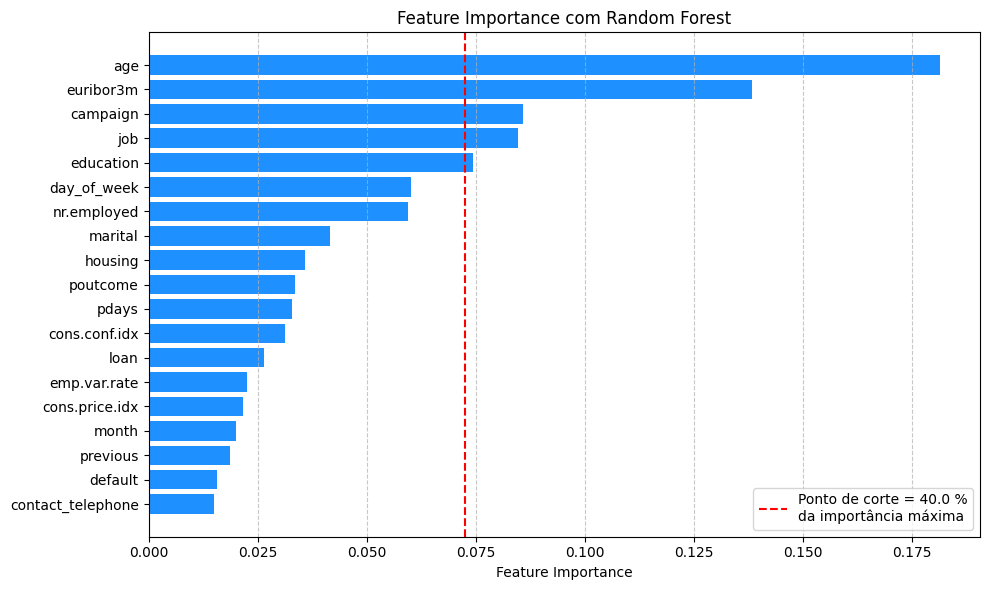

In [ ]:
# Calculando e visualizando a Feature Importance
lista_fs_importance = fs_importance(X_train , y_train , cutoff_importance = 0.4, plot=True)

###Método 3 - Dropagem de features constantes e features correlacionadas

In [ ]:
# Chamando a função e salvando a lista de features seleciondas
lista_features_var_and_corr = fs_variance_and_correlation(X_train , y_train ,
                                     model=DecisionTreeClassifier(),
                                     threshold_variance=0 ,
                                     threshold_correlation=0.75)


Features de baixa variância removidas: 0
Features de alta correlação removidas: 7
Features remanescentes: 21



###Método 4 - Boruta

In [ ]:
# Chamando a função
lista_fs_boruta = fs_boruta(X_train , y_train)

###Método 5 - Eliminação recursiva de features

In [ ]:
# Quantidade de variáveis a seremmantidas igual a quantidade da FeatureImportance
n = len(lista_fs_importance)

# Chamando a função e salvando a lista de features seleciondas
lista_features_rfe = fs_rfe(X_train , y_train , model=DecisionTreeClassifier(), n_vars_keep=n)


Features removidas: 23
Features remanescentes: 5



##Resumo

In [ ]:
# Quantidade de features selecionadas por cada método
data = [
    {'Método': 'PCA+IV', 'Features selecionadas': len(lista_fs_iv)},
    {'Método': 'Feat Import', 'Features selecionadas': len(lista_fs_importance)},
    {'Método': 'Vari e Corr', 'Features selecionadas': len(lista_features_var_and_corr)},
    {'Método': 'Boruta', 'Features selecionadas': len(lista_fs_boruta)},
    {'Método': 'RFE', 'Features selecionadas': len(lista_features_rfe)}
]

# Crie um DataFrame a partir da lista de dicionários
df_qtd = pd.DataFrame(data)

# Exiba o DataFrame
df_qtd

,Método,Features selecionadas
0,PCA+IV,3
1,Feat Import,5
2,Vari e Corr,21
3,Boruta,2
4,RFE,5


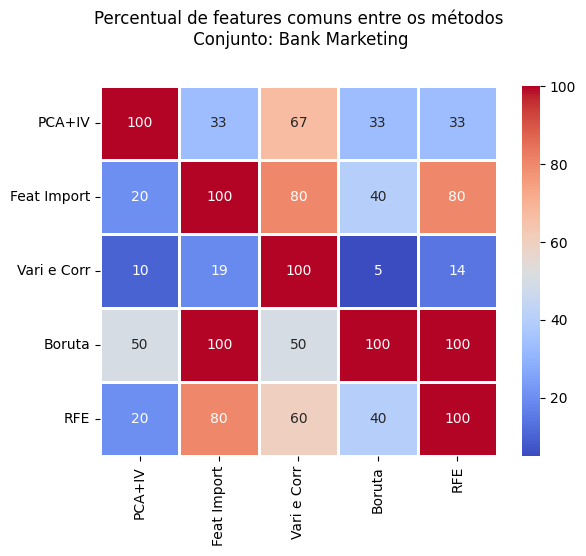

In [ ]:
# Crie um dicionário onde as chaves são os rótulos das colunas e os valores são as listas
df_listas = {
    'PCA+IV': lista_fs_iv,
    'Feat Import': lista_fs_importance,
    'Vari e Corr': lista_features_var_and_corr,
    'Boruta': lista_fs_boruta,
    'RFE': lista_features_rfe
}

# Inicialize um DataFrame com zeros
df_resumo = pd.DataFrame(0, columns=df_listas.keys(), index=df_listas.keys())

# Calcule o percentual de valores em comum entre as listas em relação ao tamanho da lista de referência
for col1 in df_resumo.columns:
    for col2 in df_resumo.columns:
        common_values = len(set(df_listas[col1]).intersection(df_listas[col2]))
        percent_common = round((common_values / len(df_listas[col1])) * 100,0)
        df_resumo.at[col1, col2] = percent_common

# Crie o heatmap
ax = sns.heatmap(df_resumo, annot=True, linewidth=1, cmap='coolwarm' , fmt='d')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Percentual de features comuns entre os métodos\n Conjunto: Bank Marketing', pad=30)

# Exiba o heatmap
plt.show()

NOTA:

Como a quantidade de features selecionadas por cada método nem sempre é igual, ao analisar o mapa, para cada par de combinação é possível encontrar dois valores distintos de percentual de features comuns

Exemplo hipotético:

* **Eixo vertical Boruta / Eixo horizontal Feature Importance: 100%**

  Isso quer dizer que o Buruta contém 100% das features que foram selecionadas pelo Feature Importance.

* **Eixo vertical Feature Importance / Eixo horizontal Boruta: 67%**

  Isso quer dizer que o Feature Importance contém 67% das features selecionadas pelo Boruta.


Quando o par de valores for alto e esses valores forem próximos, significa que ambos os métodos sleecionaram aproximadamente a mesma quantidade de features, como muitas delas sendo comuns aos dois. Esta informação pode ser útil para validar a lista final de features selecionada por um método.

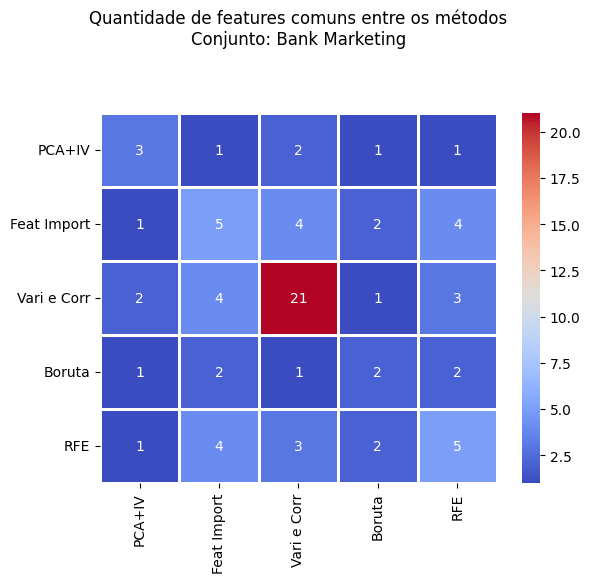

In [ ]:
# Mapa por quantidade

# Inicialize um DataFrame com zeros
df_resumo = pd.DataFrame(0, columns=df_listas.keys(), index=df_listas.keys())

# Calcule a quantidade de valores em comum entre as listas
for col1 in df_resumo.columns:
    for col2 in df_resumo.columns:
        common_values = len(set(df_listas[col1]).intersection(df_listas[col2]))
        df_resumo.at[col1, col2] = common_values

# Crie o heatmap
ax = sns.heatmap(df_resumo, annot=True, linewidth=1, cmap='coolwarm', fmt='d')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Quantidade de features comuns entre os métodos\nConjunto: Bank Marketing', pad=50)

# Exiba o heatmap
plt.show()

#Home Credit Default Risk

Fonte: kaggle.com/competitions/home-credit-default-risk

##Preparação dos dados

In [ ]:
# Importação dos dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Feature selection - estudo/HomeCredit_application_train.csv' , sep=',')

In [ ]:
# Visualizando
df.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dropando a feature 'SK_ID_CURR':
df.drop('SK_ID_CURR' , axis=1 , inplace=True)

In [ ]:
# Criando os metadados
df_report = report_data(df)
df_report

,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,TARGET,int64,2,0.0,8.1,0.0,8.1,0.0,91.9
1,NAME_CONTRACT_TYPE,object,2,0.0,0.0,0.0,0.0,Cash loans,90.5
2,CODE_GENDER,object,3,0.0,0.0,0.0,0.0,F,65.8
3,FLAG_OWN_CAR,object,2,0.0,0.0,0.0,0.0,N,66.0
4,FLAG_OWN_REALTY,object,2,0.0,0.0,0.0,0.0,Y,69.4
...,...,...,...,...,...,...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,float64,9,13.5,0.5,0.0,0.6,0.0,86.0
117,AMT_REQ_CREDIT_BUREAU_WEEK,float64,9,13.5,2.8,0.0,3.2,0.0,83.7
118,AMT_REQ_CREDIT_BUREAU_MON,float64,24,13.5,14.2,0.0,16.5,0.0,72.3
119,AMT_REQ_CREDIT_BUREAU_QRT,float64,11,13.5,16.4,0.0,19.0,0.0,70.1


In [ ]:
# Preparação dos dados
S = fs_dataprep(df,'TARGET',df_report, lim_miss=80 , lim_card=5, scaled='all')

In [ ]:
# Restaurando os dados de treino (redução do nome para facilidade)
X_train = S.X_train_enc_std
y_train = S.y_train

##Feature selection

###Método 1: PCA + IV

In [ ]:
# Chamando a função do PCA
lista_fs_pca, result_df = fs_pca(X_train , variance_explained=0.95 , features_per_component=1)

# Criando dataframe auxiliar, juntando X e y
df_aux = S.X_train_enc

# Selecionando somente as variáveis do PCA
df_aux = df_aux[lista_fs_pca]

# Adicionando o target
df_aux['TARGET'] = S.y_train

# Chamando a função
lista_fs_iv, df_iv = select_features_by_iv_discretized(df_aux, 'TARGET', iv_cutoff_ratio=0.25, bins=10)

Calculating IV: 100%|██████████| 64/64 [00:16<00:00,  3.99variable/s]


###Método 2 - Feature importance com RandomForest

In [ ]:
# Calculando e visualizando a Feature Importance
lista_fs_importance = fs_importance(X_train , y_train , cutoff_importance = 0.4, plot=True)


Features removidas: 116
Features remanescentes: 14

O gráfico não será exibido devido a grande quantidade de features



<Figure size 1000x600 with 0 Axes>

###Método 3 - Dropagem de features constantes e features correlacionadas

In [ ]:
# Chamando a função e salvando a lista de features seleciondas
lista_features_var_and_corr = fs_variance_and_correlation(X_train , y_train ,
                                     model=DecisionTreeClassifier(),
                                     threshold_variance=0 ,
                                     threshold_correlation=0.75)


Features de baixa variância removidas: 0
Features de alta correlação removidas: 45
Features remanescentes: 85



###Método 4 - Boruta

In [ ]:
# Chamando a função
lista_fs_boruta = fs_boruta(X_train , y_train)

###Método 5 - Eliminação recursiva de features

In [ ]:
# Quantidade de variáveis a seremmantidas igual a quantidade da FeatureImportance
n = len(lista_fs_importance)

# Chamando a função e salvando a lista de features seleciondas
lista_features_rfe = fs_rfe(X_train , y_train , model=DecisionTreeClassifier(), n_vars_keep=n)


Features removidas: 116
Features remanescentes: 14



##Resumo

In [ ]:
# Quantidade de features selecionadas por cada método
data = [
    {'Método': 'PCA+IV', 'Features selecionadas': len(lista_fs_iv)},
    {'Método': 'Feat Import', 'Features selecionadas': len(lista_fs_importance)},
    {'Método': 'Vari e Corr', 'Features selecionadas': len(lista_features_var_and_corr)},
    {'Método': 'Boruta', 'Features selecionadas': len(lista_fs_boruta)},
    {'Método': 'RFE', 'Features selecionadas': len(lista_features_rfe)}
]

# Crie um DataFrame a partir da lista de dicionários
df_qtd = pd.DataFrame(data)

# Exiba o DataFrame
df_qtd

,Método,Features selecionadas
0,PCA+IV,2
1,Feat Import,14
2,Vari e Corr,85
3,Boruta,5
4,RFE,14


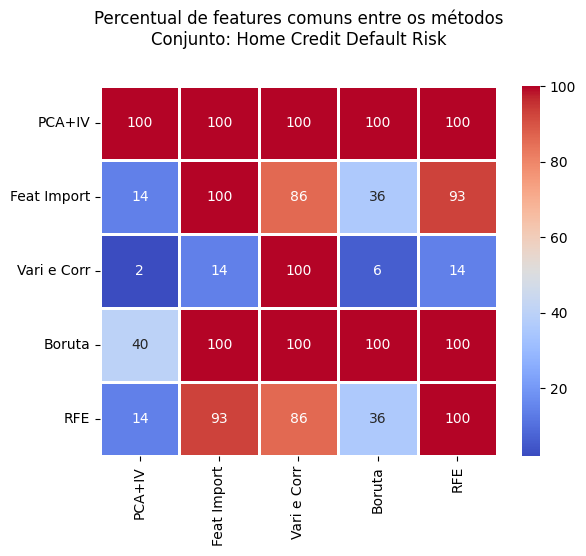

In [ ]:
# Crie um dicionário onde as chaves são os rótulos das colunas e os valores são as listas
df_listas = {
    'PCA+IV': lista_fs_iv,
    'Feat Import': lista_fs_importance,
    'Vari e Corr': lista_features_var_and_corr,
    'Boruta': lista_fs_boruta,
    'RFE': lista_features_rfe
}

# Inicialize um DataFrame com zeros
df_resumo = pd.DataFrame(0, columns=df_listas.keys(), index=df_listas.keys())

# Calcule o percentual de valores em comum entre as listas em relação ao tamanho da lista de referência
for col1 in df_resumo.columns:
    for col2 in df_resumo.columns:
        common_values = len(set(df_listas[col1]).intersection(df_listas[col2]))
        percent_common = round((common_values / len(df_listas[col1])) * 100,0)
        df_resumo.at[col1, col2] = percent_common

# Crie o heatmap
ax = sns.heatmap(df_resumo, annot=True, linewidth=1, cmap='coolwarm' , fmt='d')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Percentual de features comuns entre os métodos\nConjunto: Home Credit Default Risk', pad=30)

# Exiba o heatmap
plt.show()

NOTA:

Como a quantidade de features selecionadas por cada método nem sempre é igual, ao analisar o mapa, para cada par de combinação é possível encontrar dois valores distintos de percentual de features comuns

Exemplo hipotético:

* **Eixo vertical Boruta / Eixo horizontal Feature Importance: 100%**

  Isso quer dizer que o Buruta contém 100% das features que foram selecionadas pelo Feature Importance.

* **Eixo vertical Feature Importance / Eixo horizontal Boruta: 67%**

  Isso quer dizer que o Feature Importance contém 67% das features selecionadas pelo Boruta.


Quando o par de valores for alto e esses valores forem próximos, significa que ambos os métodos sleecionaram aproximadamente a mesma quantidade de features, como muitas delas sendo comuns aos dois. Esta informação pode ser útil para validar a lista final de features selecionada por um método.

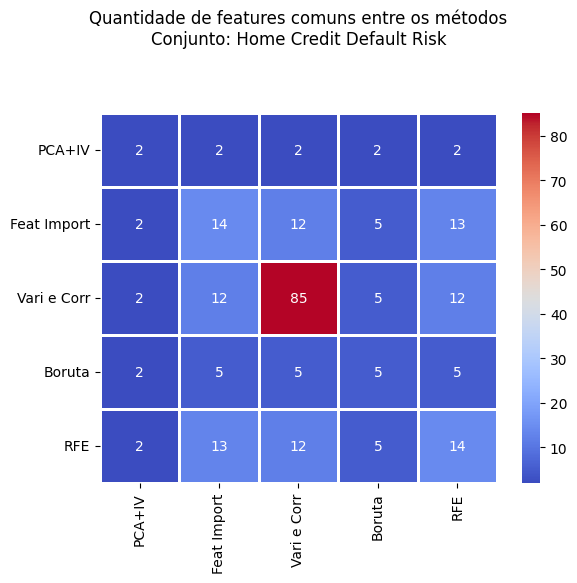

In [ ]:
# Mapa por quantidade

# Inicialize um DataFrame com zeros
df_resumo = pd.DataFrame(0, columns=df_listas.keys(), index=df_listas.keys())

# Calcule a quantidade de valores em comum entre as listas
for col1 in df_resumo.columns:
    for col2 in df_resumo.columns:
        common_values = len(set(df_listas[col1]).intersection(df_listas[col2]))
        df_resumo.at[col1, col2] = common_values

# Crie o heatmap
ax = sns.heatmap(df_resumo, annot=True, linewidth=1, cmap='coolwarm', fmt='d')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Quantidade de features comuns entre os métodos\nConjunto: Home Credit Default Risk', pad=50)

# Exiba o heatmap
plt.show()